# Pytorch Geometric

- (Node Classification Example](https://www.youtube.com/watch?v=ex2qllcVneY) and associated [collab notebook](https://colab.research.google.com/drive/1LJir3T6M6Omc2Vn2GV2cDW_GV2YfI53_?usp=sharing)


In [1]:
!python -c "import torch; print(torch.version.cuda)"

10.2


In [2]:
## Cora datasets -- publications and citations as connections 
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

Processing...
Done!


In [80]:
dataset.name
dataset[0]

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])

In [72]:
# Get some basic info about the dataset
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(50*'=')

# There is only one graph in the dataset, use it as new data object
data = dataset[0]  

# Gather some statistics about the graph.
print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Is undirected: {data.is_undirected()}')

Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])
Number of nodes: 2708
Number of edges: 10556
Number of training nodes: 140
Training node label rate: 0.05
Is undirected: True


In [73]:
print(data.x.shape) # [No. Nodes x Features]

# Print some of the normalized word counts of the first datapoint
data.x[0][:50]

torch.Size([2708, 1433])


tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [74]:
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [75]:
 print(data.edge_index, "\n of shape >>> ", data.edge_index.shape)

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]]) 
 of shape >>>  torch.Size([2, 10556])


In [76]:
print("Edge feature matrix with shape: ", data.edge_attr, "\n", data.edge_attr)

print("Node position nmatrix with shape: ", data.pos, "\n", data.pos)

Edge feature matrix with shape:  None 
 None
Node position nmatrix with shape:  None 
 None


In [78]:
data.keys

['x', 'edge_index', 'y', 'train_mask', 'val_mask', 'test_mask']

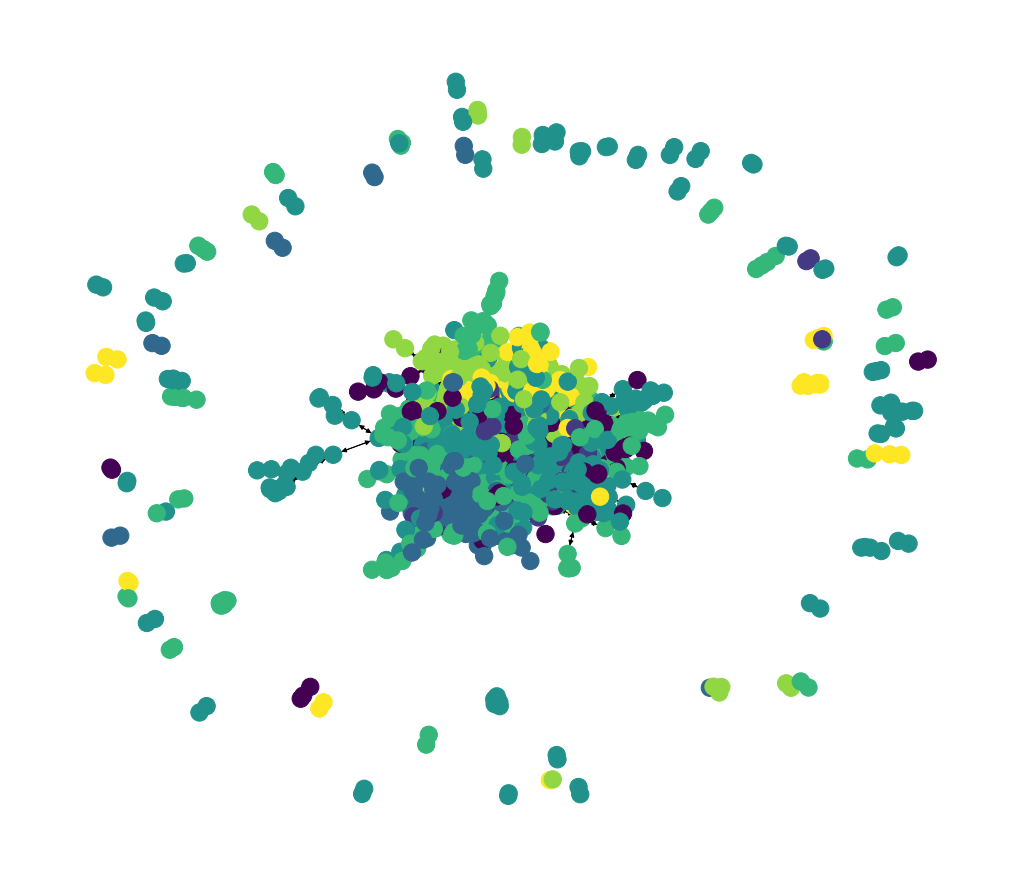

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline

from torch_geometric.utils.convert import to_networkx

g2 = to_networkx( data ) 

plt.figure(1, figsize=(14,12))
nx.draw( g2, node_color=data.y)
plt.show();

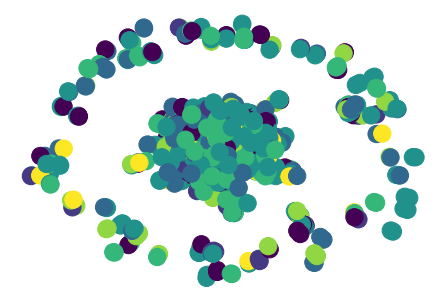

In [82]:
import networkx as nx
g = nx.Graph()

for i, j in zip(data.edge_index[0].numpy(), data.edge_index[1].numpy() ):
    g.add_edge( i, j)
    
nx.draw( g, node_color=data.y)

In [7]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv #GATConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # Initialize the layers
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Second Message Passing Layer
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Output layer 
        x = F.softmax(self.out(x), dim=1)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (out): Linear(in_features=16, out_features=7, bias=True)
)


In [8]:
# Initialize model
model = GCN(hidden_channels=16)

# Use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data = data.to(device)

# Initialize Optimizer
learning_rate = 0.01
decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate, 
                             weight_decay=decay)
# Define loss function (CrossEntropyLoss for Classification Problems with 
# probability distributions)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad() 
      # Use all data as input, because all nodes have node features
      out = model(data.x, data.edge_index)  
      # Only use nodes with labels available for loss calculation --> mask
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  
      loss.backward() 
      optimizer.step()
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      # Use the class with highest probability.
      pred = out.argmax(dim=1)  
      # Check against ground-truth labels.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  
      # Derive ratio of correct predictions.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  
      return test_acc

losses = []
for epoch in range(0, 1001):
    loss = train()
    losses.append(loss)
    if epoch % 100 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 000, Loss: 1.9460
Epoch: 100, Loss: 1.6487
Epoch: 200, Loss: 1.4869
Epoch: 300, Loss: 1.4474
Epoch: 400, Loss: 1.3799
Epoch: 500, Loss: 1.3603
Epoch: 600, Loss: 1.3614
Epoch: 700, Loss: 1.3271
Epoch: 800, Loss: 1.3495
Epoch: 900, Loss: 1.3234
Epoch: 1000, Loss: 1.2998


# Intro Tutorial  
- [Geometric Deep Learning collxn](http://geometricdeeplearning.com/) 

- [A 2015 basics doc](http://www.080910t.com/wp-content/uploads/2019/06/Hands-on-Graph-Neural-Networks-with-PyTorch-PyTorch-Geometric1.pdf)
- []()

In [11]:
import torch
from torch_geometric.data import Data

In [66]:
node_x = torch.tensor([[2,1], [5,6], [3,7], [12,0]], dtype=torch.float)
node_y = torch.tensor([0,1,0,1], dtype=torch.float)
adj_m = torch.tensor([
    [0,1,2,0,3],
    [1,0,1,3,2]], dtype=torch.long)

graph = Data(x=node_x, y=node_y, edge_index=adj_m)

print( graph.keys )
graph

['x', 'edge_index', 'y']


Data(edge_index=[2, 5], x=[4, 2], y=[4])

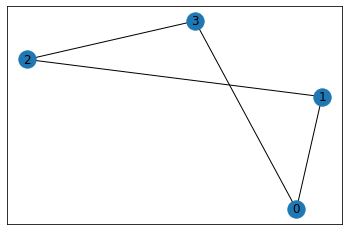

In [67]:
import networkx as nx
g = nx.Graph()

for i, j in zip(adj_m[0].numpy(), adj_m[1].numpy() ):
    g.add_edge( i, j)
    
nx.draw_networkx(g)

# YATE

- Note that edge_index, i.e. the tensor defining the source and target nodes of all edges, is not a list of index tuples. If you want to write your indices this way, you should transpose and call contiguous on it before passing them to the data constructor: `edge_index.t().contiguous()` 

- 



In [23]:
import torch
from torch_geometric.data import Data

In [31]:
edgez = torch.tensor([[0,1,1,2],[1,0,2,1]], dtype=torch.long)
node_x = torch.tensor([[-1], [0],[1]], dtype=torch.float)

data = Data(x=node_x, edge_index=edgez)
data

Data(edge_index=[2, 4], x=[3, 1])

In [32]:
print(data.keys)

['x', 'edge_index']


In [34]:
# transfer data object to GPU
dev = torch.device('cuda')
gdata = data.to(dev)
print(gdata.keys)
gdata

['x', 'edge_index']


Data(edge_index=[2, 4], x=[3, 1])

In [35]:
## Enzymes dataset
from torch_geometric.datasets import TUDataset
enz_datasets = TUDataset(root='/tmp/ENZYMES', name='ENZYMES') 

Extracting /tmp/ENZYMES/ENZYMES/ENZYMES.zip
Processing...
Done!


In [39]:
print(len(enz_datasets), enz_datasets.num_classes, enz_datasets.num_node_labels)
print(enz_datasets[0].is_undirected(), enz_datasets[0].num_nodes )

600 6 3
True 37


In [40]:
import networkx as nx
import numpy as np

from torch_geometric.utils import to_networkx


def draw_molecule(g, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')
    
    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}    
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red')
    plt.show()


def to_molecule(data):
    ATOM_MAP = ['C', 'O', 'Cl', 'H', 'N', 'F',
                'Br', 'S', 'P', 'I', 'Na', 'K', 'Li', 'Ca']
    g = to_networkx(data, node_attrs=['x'])
    for u, data in g.nodes(data=True):
        data['name'] = ATOM_MAP[data['x'].index(1.0)]
        del data['x']
    return g


In [43]:
# m = to_molecule( data )
# plt.figure(figsize=(10,5))
# draw_molecule(mol)

tensor([[ 2.,  1.],
        [ 5.,  6.],
        [ 3.,  7.],
        [12.,  0.]]) 

 y = tensor([0., 1., 0., 1.]) 

 e =  tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])


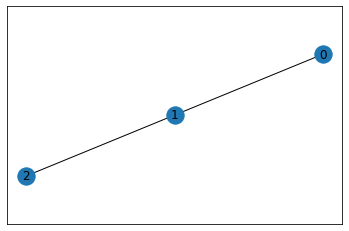

In [55]:
import networkx as nx

print(node_x, "\n\n y =", node_y, "\n\n e = ", edgez)

g = nx.Graph( )

for i, j in zip( edgez[0].numpy(), edgez[1].numpy() ):
    g.add_edge( i, j)
    
nx.draw_networkx(g)


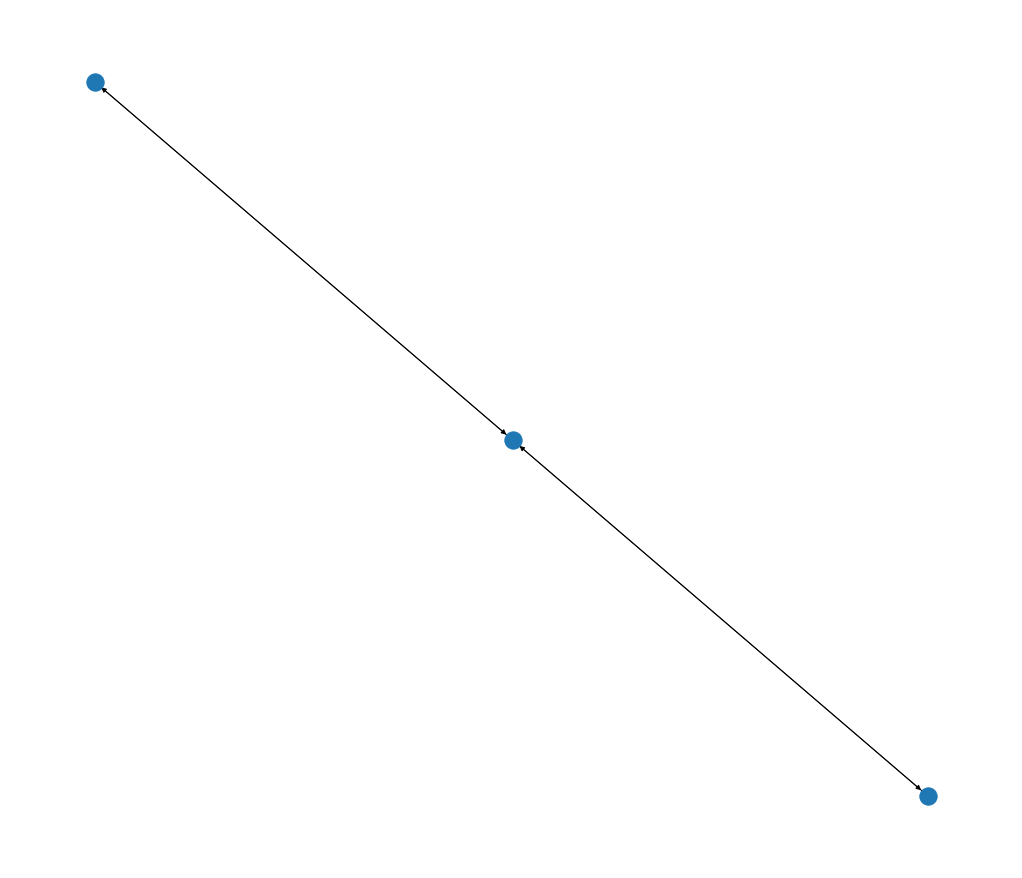

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

from torch_geometric.utils.convert import to_networkx

g2 = to_networkx( gdata ) 

plt.figure(1, figsize=(14,12))
nx.draw( g2)
plt.show();

# Model Intepretability for Pytorch - [Captum](https://captum.ai/)

# TODO

- https://github.com/mlaskowski17/Pytorch-Geometric/blob/master/pytorch_geometric_introduction.py 

- [Graph U-Net](https://openreview.net/pdf?id=HJePRoAct7) 
- [Learning Representations from fMRI](https://tel.archives-ouvertes.fr/tel-01891633/document) 